## Install Libraries

In [2]:
!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/66/82/564168a349148298aca281e342551404ef5521f33fba17b388ead0a84dc5/opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 27.8 MB/s eta 0:00:0000:0100:01


In [3]:
import tensorflow as tf
import os
import numpy as np
import random
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from tqdm import tqdm 

## Define Constants

In [54]:
HOME = os.getcwd()
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
print(HOME)

/Users/ivynyak/Documents/GitHub/scdf-dell-2024


## Resize Images

In [56]:
def resize_all(path, length, X, Y):
    for i in tqdm(range(1, length + 1), desc='Processing images'):
        IMG_PATH = f"{HOME}{path}images/img({i}).jpg"
        MASK_PATH = f"{HOME}{path}masks/img({i}).png"

        img = imread(IMG_PATH)[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[i-1] = img

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
        mask_ = imread(MASK_PATH)
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        mask_ = np.expand_dims(mask_, axis=-1)
        mask = np.maximum(mask, mask_)

        Y[i-1] = mask

    return X, Y

In [57]:
TRAIN_PATH = '/dataset/train/'
TEST_PATH = '/dataset/test/'

TRAIN_LENGTH = len(os.listdir(HOME + '/dataset/train/images'))
TEST_LENGTH = len(os.listdir(HOME + '/dataset/test/images'))

X_train = np.zeros((len(os.listdir(HOME + '/dataset/train/images')), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(HOME + '/dataset/train/images')), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

X_test = np.zeros((len(os.listdir(HOME + '/dataset/test/images')), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(HOME + '/dataset/test/images')), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)


In [58]:
X_test, Y_test = resize_all(TEST_PATH, TEST_LENGTH, X_test, Y_test)

Processing images: 100%|██████████████████████| 100/100 [00:07<00:00, 12.70it/s]


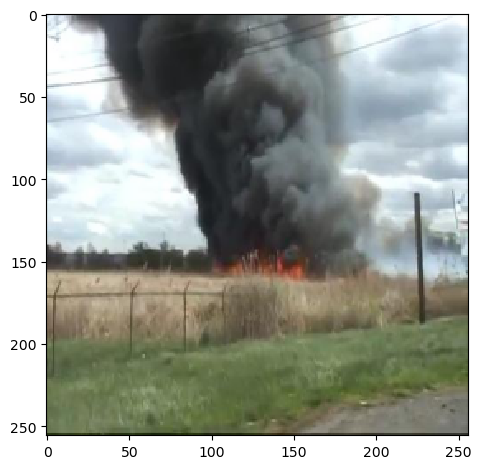

In [59]:
image_test = random.randint(0, TEST_LENGTH)

## Show actual vs masked image
img = X_test[image_test]
imshow(img)

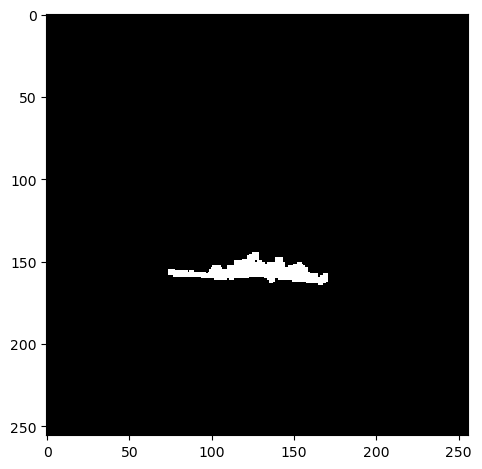

In [60]:
img = np.squeeze(Y_test[image_test])
imshow(img)

In [61]:
X_train, Y_train = resize_all(TRAIN_PATH, TRAIN_LENGTH, X_train, Y_train)

Processing images: 100%|██████████████████████| 500/500 [01:39<00:00,  5.01it/s]


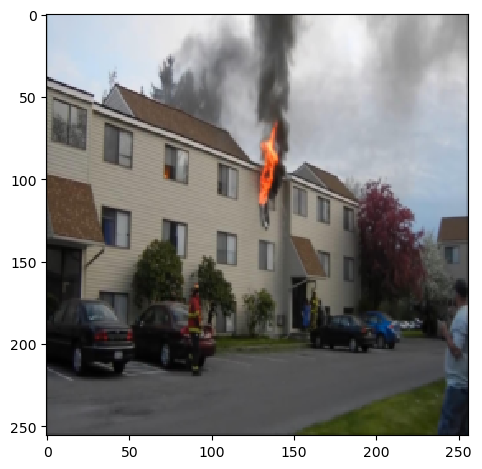

In [62]:
image_train = random.randint(0, TRAIN_LENGTH)

## Show actual vs masked image
img = X_train[image_train]
imshow(img)

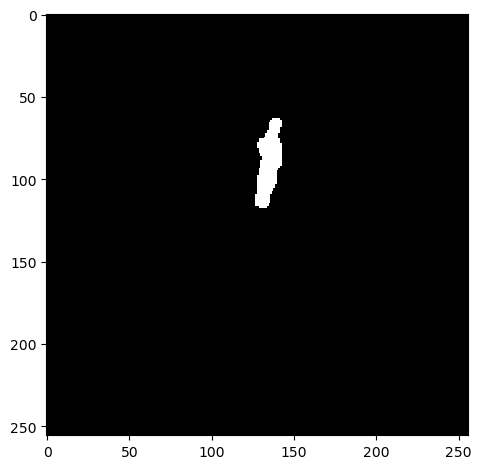

In [63]:
img = np.squeeze(Y_train[image_train])
imshow(img)

## U-Net Set Up

In [64]:
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x : x/255)(inputs)

#contraction
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#expansive
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)


In [65]:
outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        448 │ lambda_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_12[0][0]

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("fire_segmentation.keras", verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs/'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

]

In [67]:
result = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)


Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.9294 - loss: 0.3331 - val_accuracy: 0.9105 - val_loss: 0.2474 - learning_rate: 0.0010
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.9412 - loss: 0.1396 - val_accuracy: 0.9374 - val_loss: 0.1539 - learning_rate: 0.0010
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.9606 - loss: 0.1035 - val_accuracy: 0.9665 - val_loss: 0.1238 - learning_rate: 0.0010
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.9671 - loss: 0.0955 - val_accuracy: 0.9699 - val_loss: 0.1042 - learning_rate: 0.0010
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.9691 - loss: 0.0916 - val_accuracy: 0.9676 - val_loss: 0.1060 - learning_rate: 0.0010
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.9698 - loss: 0.0852 - val_accuracy: 0.9676 - val_loss: 0.1095 - learning_rate: 0.0010
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.9718 - loss: 0.0852 - val_acc

## Evaluation

In [68]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

15/15 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


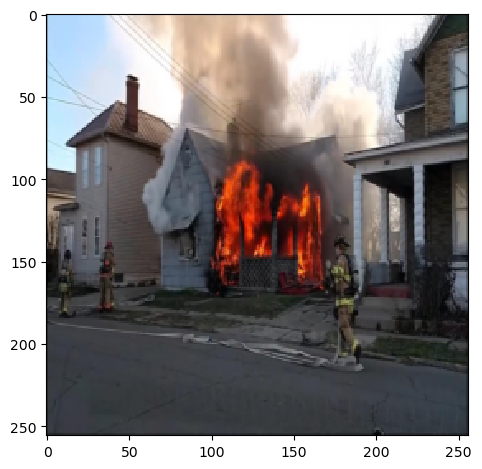

In [69]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])

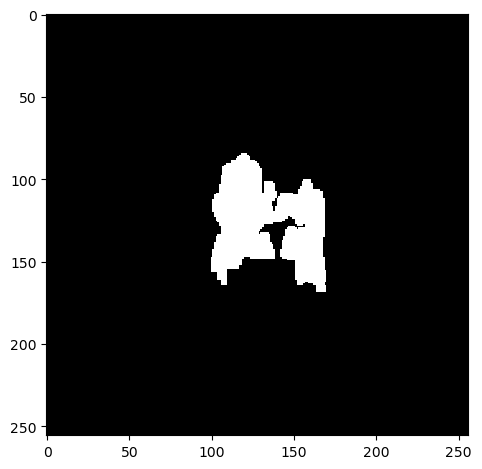

In [70]:
imshow(np.squeeze(Y_train[ix]))

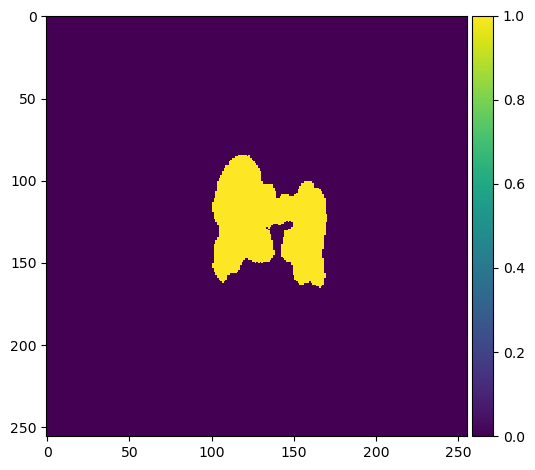

In [71]:
imshow(np.squeeze(preds_train_t[ix]))

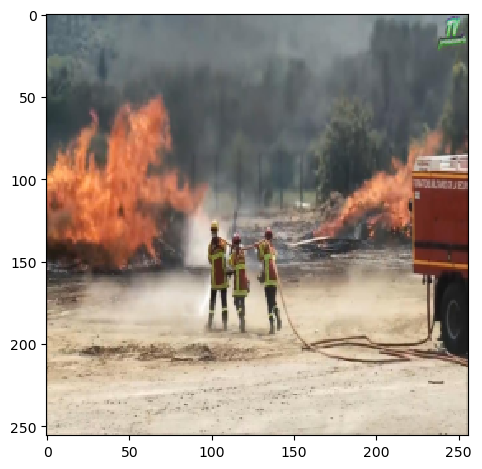

In [72]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])

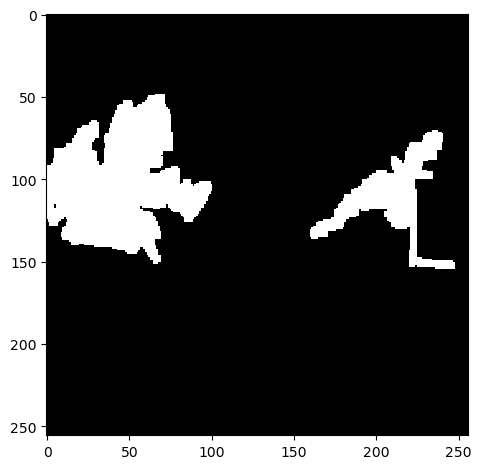

In [73]:
imshow(np.squeeze(Y_test[ix]))

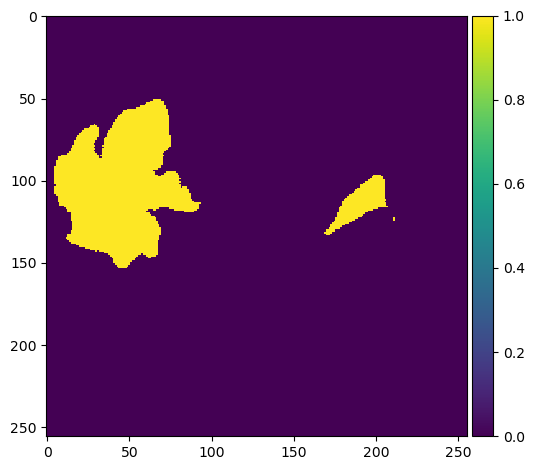

In [74]:
imshow(np.squeeze(preds_test_t[ix]))